<a href="https://colab.research.google.com/github/theoVasilas/NN_training/blob/collab/MINIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dowload dataset and imports

In [ ]:
%%capture
%pip install torch
%pip install torchvision
#captured_output.show()

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.utils import io
import numpy as np


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36127754.28it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1047650.99it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9422785.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 526781.57it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## tranforms


In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = False,
    transform = transform_train
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = False,
    transform=transform_test
)

## loaders

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'valid' : torch.utils.data.DataLoader(val_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)
}


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


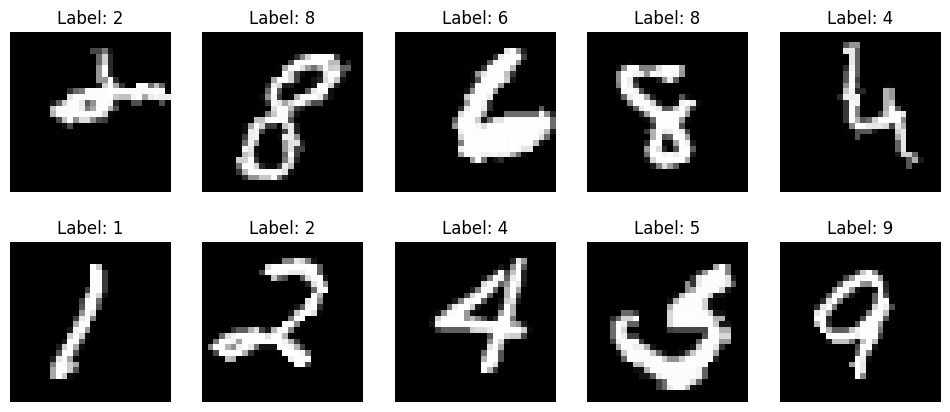

In [ ]:
train_loader = loaders['train']
data_iter = iter(train_loader)

# Plot 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    images, labels = next(data_iter)
    ax = axes[i // 5, i % 5]
    ax.imshow(images[0].permute(1, 2, 0).squeeze(), cmap='gray')  # Assuming images are in CHW format
    ax.set_title(f"Label: {labels[0]}")
    ax.axis('off')

plt.show()

## Simple CNN

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


cnn = CNN()

## My_CNN

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=24,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=32,
                kernel_size=2,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3)

        )

        self.linear1 = nn.Linear(in_features=32 * 7 * 7, out_features=24)

        self.drop = nn.Dropout(p=0.3)

        self.linear2 = nn.Linear(in_features=24, out_features=num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)

        x = self.linear1(x)
        x = nn.functional.relu(x)

        x = self.drop(x)

        x = self.linear2(x)

        output = torch.log_softmax(x, dim=1)
        return output

Cnet = Net(num_classes=10).to(device)

print(Cnet)


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (linear1): Linear(in_features=1568, out_features=24, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=24, out_features=10, bias=True)
)


In [ ]:
# %%capture
# !pip install torchviz

import torch
from torchviz import make_dot


dummy_input = torch.randn(1, 1, 28, 28).to(device)

dot = make_dot(Cnet(dummy_input), params=dict(Cnet.named_parameters()))

dot.render("CNN_visualization", format="png")

dot

In [ ]:
from torch import optim

learning_rate = 0.001

optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)

loss_func = nn.CrossEntropyLoss()

## updated training


Epoch [1/100], Train Loss: 2.3083, Train Accuracy: 10.01%, Val Loss: 2.3072, Val Accuracy: 10.14%
Epoch [2/100], Train Loss: 2.3084, Train Accuracy: 9.99%, Val Loss: 2.3071, Val Accuracy: 10.26%
Epoch [3/100], Train Loss: 2.3084, Train Accuracy: 10.07%, Val Loss: 2.3071, Val Accuracy: 10.13%
Epoch [4/100], Train Loss: 2.3084, Train Accuracy: 10.08%, Val Loss: 2.3071, Val Accuracy: 9.84%
Epoch [5/100], Train Loss: 2.3084, Train Accuracy: 10.01%, Val Loss: 2.3071, Val Accuracy: 10.13%
Epoch [6/100], Train Loss: 2.3084, Train Accuracy: 10.03%, Val Loss: 2.3071, Val Accuracy: 9.82%
Epoch [7/100], Train Loss: 2.3084, Train Accuracy: 9.97%, Val Loss: 2.3071, Val Accuracy: 10.22%
Epoch [8/100], Train Loss: 2.3084, Train Accuracy: 9.94%, Val Loss: 2.3071, Val Accuracy: 10.28%
Epoch [9/100], Train Loss: 2.3084, Train Accuracy: 10.08%, Val Loss: 2.3072, Val Accuracy: 10.05%
Epoch [10/100], Train Loss: 2.3084, Train Accuracy: 10.00%, Val Loss: 2.3071, Val Accuracy: 10.01%
Epoch [11/100], Train Lo

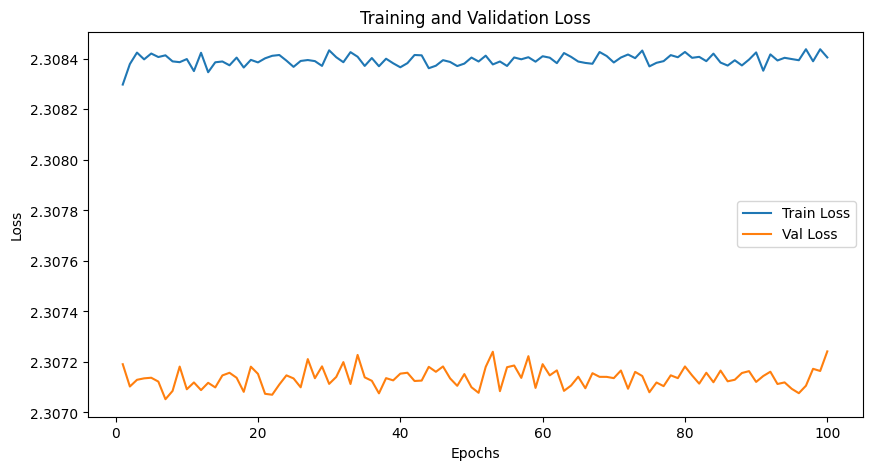

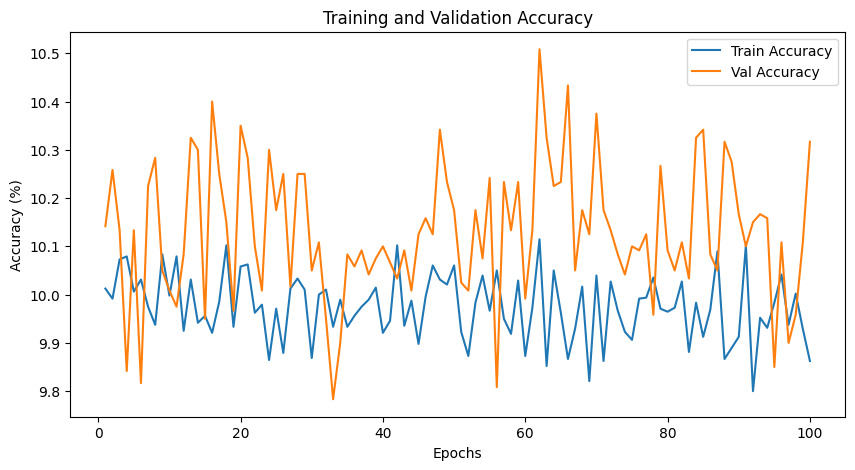

In [ ]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"

# Now import JAX
import jax

def train(model, loaders =loaders , num_epochs=20, loss_func = loss_func, optimizer = optimizer):

    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = images.requires_grad_(True).to(device)
            b_y = labels.to(device)

            output = model(b_x)
            loss = loss_func(output, b_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(output.data, 1)
            total_train += b_y.size(0)
            correct_train += (predicted_train == b_y).sum().item()

        train_loss = running_loss / len(loaders['train'])
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in loaders['valid']:
                b_x = images.requires_grad_(False).to(device)
                b_y = labels.to(device)

                output = model(b_x)
                loss = loss_func(output, b_y)
                val_loss += loss.item()

                _, predicted_val = torch.max(output.data, 1)
                total_val += b_y.size(0)
                correct_val += (predicted_val == b_y).sum().item()

        val_loss /= len(loaders['valid'])
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

train(Cnet, num_epochs = 100)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
torch.save(Cnet, "Cnet_1_trained_model.pt")

!cp  CNN_1_trained_model.pt /content/drive/MyDrive/Sxoli/EFREMIDIS

cnn = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/CNN_1_trained_model.pt')

## test

In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass

test(cnn)

In [ ]:
from sklearn.metrics import confusion_matrix

def test(cnn, loaders):
    cnn.eval()
    with torch.no_grad():
        all_predicted_labels = []
        all_true_labels = []

        for images, labels in loaders['test']:
            test_output, _ = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            all_predicted_labels.extend(pred_y.tolist())
            all_true_labels.extend(labels.tolist())

        # Calculate Test Accuracy
        accuracy = (torch.tensor(all_predicted_labels) == torch.tensor(all_true_labels)).float().mean().item()
        print('Test Accuracy of the model on the test set: %.2f' % accuracy)

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_true_labels, all_predicted_labels)
        print('Confusion Matrix:\n', cm)

        # Calculate accuracy for each class
        class_accuracies = np.diag(cm) / cm.sum(axis=1)
        for i, acc in enumerate(class_accuracies):
            print(f'Accuracy for class {i}: {acc:.2f}')

        # Visualize wrongly predicted images
        #visualize_wrong_predictions(images, all_predicted_labels, all_true_labels)

    return all_predicted_labels, all_true_labels

all_predicted_labels, all_true_labels = test(cnn, loaders)


In [ ]:
import math

def wrong_images():
    cnn.eval()
    with torch.no_grad():
        wrong_sum = 0

        for images, labels in loaders['test']:
            test_output, _ = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            wrong_indices = (pred_y != labels).nonzero(as_tuple=True)[0]
            wrong_indices = wrong_indices[:20]

            wrong_sum += len(wrong_indices)

            num_samples = min(20, len(wrong_indices))
            row_len = 5
            num_rows = math.ceil(num_samples / row_len)
            fig, axes = plt.subplots(num_rows, row_len, figsize=(10, num_rows * 2))
            fig.tight_layout(pad=1.0)

            for i, idx in enumerate(wrong_indices):
                row = i // row_len
                col = i % row_len
                ax = axes[row, col] if num_rows > 1 else axes[col]

                wrong_image = images[idx].cpu().permute(1, 2, 0)
                wrong_predicted_label = pred_y[idx].item()
                wrong_true_label = labels[idx].item()

                # Plot the wrong image
                ax.imshow(wrong_image)
                ax.set_title(f'Pred: {wrong_predicted_label}, True: {wrong_true_label}, idx: {idx}')
                ax.axis('off')

            plt.show()

        print(f'Total number of wrong predictions: {wrong_sum}')

wrong_images()
